In [3]:
import matplotlib.pyplot as plt

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

COLORS = {
    'green': '#009e73',
    'blue': '#0072b2',
    'yellow': '#f1e443',
    'orange': '#e69f03',
    'red': '#d55f00',
    'purple': '#cc79a7'
}

In [14]:
from datetime import datetime 
import numpy as np
import os

def parse_std_err(fname):
   with open(fname, "r") as f:
        lines = f.readlines() 
        for line in lines:
            # GCP
            if "real" in line:
                return float(line.split()[0])
            # Azure
            elif "elapsed" in line:
                t_string = line.split(" ")[2].split("elapsed")[0]
                t = datetime.strptime(t_string, '%M:%S.%f')
                datetime.strftime(t, '%M:%S.%f')
                return t.second + 60*t.minute + 0.000001*t.microsecond

def parse_std_out(fname):
    with open(fname, "r") as f:
        lines = f.readlines()
        for line in lines:
            if "Creating a new cluster" in line:
                start_time_str = line.split(" ")[2]
                start_time = datetime.strptime(start_time_str, '%H:%M:%S')
            if "Head node is up" in line:
                end_time_str = line.split(" ")[2]
                end_time = datetime.strptime(end_time_str, '%H:%M:%S')
            if "Successfully provisioned or found existing VM" in line:
                end_provision_time_str = line.split(" ")[2]
                end_provision_time = datetime.strptime(end_provision_time_str, '%H:%M:%S')
        up_time_seconds = float((end_time - start_time).total_seconds())
        provision_time_seconds = float((end_provision_time - end_time).total_seconds())
        return (up_time_seconds, provision_time_seconds)

def plot(provision_times, times_to_head_node_up, dirname, legend, name):
    # Create stacked bar plot
    labels = [f"{i}" for i in range(len(provision_times))]
    x = np.arange(len(provision_times))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 2))
    ax.barh(np.arange(1), np.mean(times_to_head_node_up), width, label='Time to start VM')
    ax.barh(np.arange(1), np.mean([provision_times[i] - times_to_head_node_up[i] for i in range(len(provision_times))]), width, left=times_to_head_node_up, label="Add'l time to provision")

    ax.set_xlabel('Time (s)')
    #ax.set_xlabel('sky-launch call index (0-39)')
    #ax.set_title(f'Time to provision for sky launch ({dirname})')
    #ax.set_xticks(x[::5])  # Select every 5th label
    #ax.set_xticklabels(labels[::5])  # Select every 5th label
    #ax.set_xticks(x)
    #ax.set_xticklabels(labels)
    if legend:
        ax.legend(loc="lower right")

    plt.savefig(f"skypilot_{name}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

def plot_comparison(provision_times_baseline, times_to_head_node_up_baseline, provision_times_skydentity, times_to_head_node_up_skydentity, legend, name, xlim):
    # Create stacked bar plot
    #width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 2))
    labels = ['Baseline', 'CloudGate']
    starts = [np.mean(times_to_head_node_up_baseline), np.mean(times_to_head_node_up_skydentity)]
    provisions = [np.mean(provision_times_baseline),
                  np.mean(provision_times_skydentity)]
    ax.barh(labels, starts, label='Start VM', color=COLORS['green'])
    ax.barh(labels, provisions, left=starts, label="Provision", color=COLORS['orange'])

    ax.set_xlabel('Time (s)')
    ax.set_xlim(0, xlim)
    #ax.set_xlabel('sky-launch call index (0-39)')
    #ax.set_title(f'Time to provision for sky launch ({dirname})')
    #ax.set_xticks(x[::5])  # Select every 5th label
    #ax.set_xticklabels(labels[::5])  # Select every 5th label
    #ax.set_xticks(x)
    #ax.set_xticklabels(labels)
    if legend:
        ax.legend(loc="lower right")

    plt.savefig(f"plots/skypilot_{name}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

def process_dir(dirname, legend, name):
    files = os.listdir(dirname)
    provision_times = []
    times_to_head_node_up = []
    totals = []
    for filename in files:
        if "stderr" in filename:
            totals.append(parse_std_err(os.path.join(dirname, filename)))
        if "stdout" in filename:
            up_time, provision_time = parse_std_out(os.path.join(dirname, filename))
            times_to_head_node_up.append(up_time)
            provision_times.append(provision_time)
    print(f"{dirname}: {np.mean(np.array(provision_times))} (std dev {np.std(np.array(provision_times))}) s to provision (avg), {np.mean(np.array(times_to_head_node_up))} s (std dev {np.std(np.array(times_to_head_node_up))}) to head node up (avg)")
    print(f"{dirname}: {np.mean(np.array(totals))} (std dev {np.std(np.array(totals))}) s total")
    return provision_times, times_to_head_node_up
    #plot(provision_times, times_to_head_node_up, dirname, legend, name)

In [5]:
def process_batch_times(fname):
    with open(fname, "r") as f:
        lines = f.readlines()
        times = []
        total = 0
        for line in lines:
            if "BATCH TIME (s):" in line:
                times.append(10.0/float(line.split()[-1]))
            if "TOTAL TIME (s):" in line:
                total = 40.0/float(line.split()[-1])
        return (times, total)

def plot_batch_times(baseline_fname, skydentity_fname, cloud, batch_size=10):
    baseline_times, baseline_total = process_batch_times(baseline_fname)
    baseline_times.append(baseline_total)
    print(f"Throughput (baseline): batch {np.mean(baseline_times)}, overall {baseline_total}")
    skydentity_times, skydentity_total = process_batch_times(skydentity_fname)
    skydentity_times.append(skydentity_total)
    print(f"Throughput (skydentity): batch {np.mean(skydentity_times)}, overall {skydentity_total}")
    x = np.arange(len(baseline_times)) + 2
    width = 0.35
    fig, ax = plt.subplots(figsize=(10, 2))
    ax.bar(x - width/2, baseline_times, width, label='Baseline', color=COLORS['blue'])
    ax.bar(x + width/2, skydentity_times, width, label='w/ CloudGate', color=COLORS['green'])
    ax.set_ylabel('Req/s')
    ax.set_title(f"Throughput ({batch_size} parallel requests)")
    ax.set_xticks(x)
    x_labels = [f"Group {i}" for i in range(len(baseline_times))]
    x_labels[-1] = "Total"
    ax.set_xticklabels(x_labels)
    ax.legend(loc="lower right")
    plt.savefig(f"plots/batch_times_{cloud}_{batch_size}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

logs/azure_baseline/1: 244.45 (std dev 34.41798221860195) s to provision (avg), 181.3 s (std dev 11.522152576667262) to head node up (avg)
logs/azure_baseline/1: 450.922 (std dev 46.43719647007127) s total
logs/skydentity_skypilot_optimized_azure: 255.35 (std dev 31.80845013514491) s to provision (avg), 184.7 s (std dev 26.5971803016786) to head node up (avg)
logs/skydentity_skypilot_optimized_azure: 462.6795 (std dev 46.659411534544674) s total


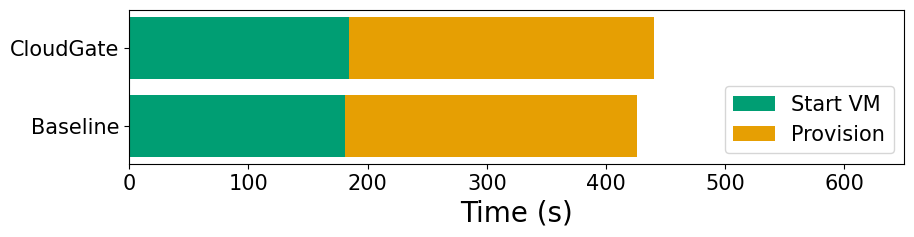

In [25]:
b1, b2 = process_dir("logs/azure_baseline/1", False, "baseline")
s1, s2 = process_dir("logs/skydentity_skypilot_optimized_azure", True, "skydentity")
plot_comparison(b1, b2, s1, s2, True, "average_latency_azure", 650)

Throughput (baseline): batch 0.019194745999806178, overall 0.01916113065160589
Throughput (skydentity): batch 0.019401463109975453, overall 0.01937592685147051


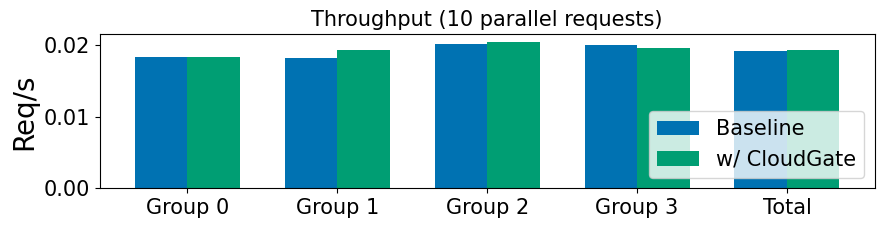

In [9]:
plot_batch_times("logs/azure_baseline/1/times.txt", "logs/skydentity_skypilot_optimized_azure/times.txt", "azure")

logs/baseline_10/run1: 91.725 (std dev 2.932469096171347) s to provision (avg), 65.0 s (std dev 6.7712628068920795) to head node up (avg)
logs/baseline_10/run1: 172.09075 (std dev 7.524894147926601) s total
logs/with_skydentity_10/run1: 93.225 (std dev 2.612350474189862) s to provision (avg), 64.525 s (std dev 5.545211898566185) to head node up (avg)
logs/with_skydentity_10/run1: 177.26925 (std dev 11.812440981334044) s total


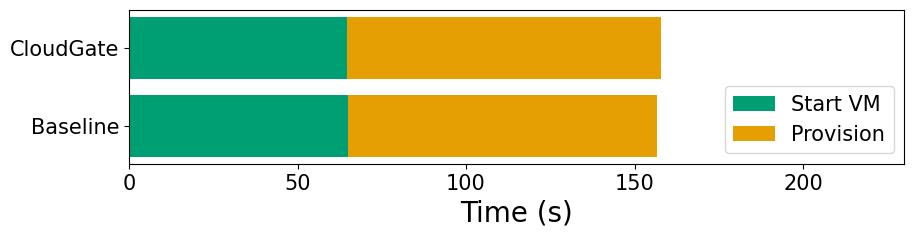

In [22]:
b1, b2 = process_dir("logs/baseline_10/run1", False, "baseline")
s1, s2 = process_dir("logs/with_skydentity_10/run1", True, "skydentity")
plot_comparison(b1, b2, s1, s2, True, "average_latency_gcp", 230)

Throughput (baseline): batch 0.05459941124172056, overall 0.05456533075304214
Throughput (skydentity): batch 0.05393580620588121, overall 0.05376783212090435


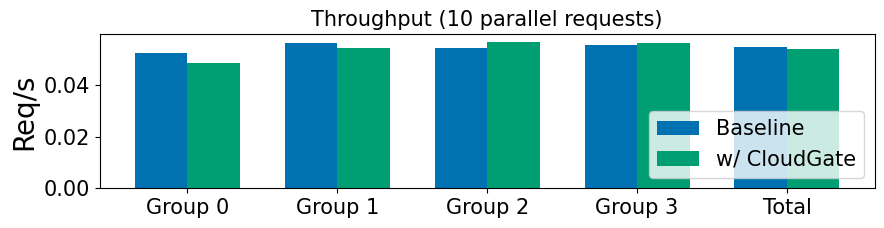

In [11]:
plot_batch_times("logs/baseline_10/run1.out", "logs/with_skydentity_batch10_run1.out", "gcp")